# Magic: The Gathering Product Analysis - Part 2
### An Analysis of Word Counts by Product Through Time
This notebook intends to analyze, and describe changes in, the word counts of Magic:The Gathering cards from its beginnings in 1993 to today (August 2023). 

This Notebook builds on a preceeding notebook which describes the "Less-Useful MTG Stats" Card Database Analysis Tool. The tool is used in the below analysis - but its features and methodology are explained only in the 'Part 1' notebook.   

Data Source for this analysis: The Scryfall Card Database API - https://scryfall.com/docs/api

Some Important Notes:
1. This is not intended as a critique, but simply an interesting excercise in data analysis and statistics. 
2. This analysis is part of a larger project: "Less-Useful MTG Stats".

## Step 1: Defining the research question(s) and goals
In the broadest sense, this project seeks to explore how the game design of Magic: The Gathering has changed over time, through a series of more focused analysis projects. 

The project highlighted in this notebook seeks to answer the following specific question:
<br>*How has the word count of Magic: The Gathering cards changed over time?*

Word count was chosen as the variable of focus in this first analysis because it reflects many important aspects of game design, eg. complexity, accessibility, ease of play.  

## Step 2: Defining the Population of Cards for Analysis
There are more than 80,000 individual card records in the Scryfall card database. Limiting this analysis only to cards that are relevant for understanding the trends in gameplay and game design was the first (and possibly most difficult) step.

TKTKTKT show pct of all playable cards by set type, then show pct of playable cards within the 4 sets limited for this analysis

In [19]:

import pandas as pd
import json as js
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime as dt
%matplotlib inline

set_types=['expansion', 'core', 'commander', 'draft_innovation']
formats = ["standard", "future", "historic", "gladiator", "pioneer", "explorer","modern","legacy",
            "pauper","vintage","penny","commander","oathbreaker","brawl","historicbrawl","alchemy","paupercommander",
            "duel","oldschool","premodern","predh"]
fname='cards8142023.json'
fnamerulings='rulings8142023.json'
incl_dupes = 'n'

print('Presets loaded for Word Count Analysis')
print('Working...')

#read in the json data and parse
cardsdf = pd.DataFrame.from_dict(js.loads(open(fname, encoding='utf8').read()))
rulingsdf = pd.DataFrame.from_dict(js.loads(open(fnamerulings, encoding = 'utf-8').read()))

#Functions defined below are all for further parsing json and building the card dataframe in a way that allows maximum flexibility
#for analysis
def set_columns(x):
    dictkeep = {
        'comment': 'Number of Rulings',
        'name': 'Card Name',
        'oracle_id': 'Oracle_ID',
        'set_type': 'Set Type',
        'oracle_text': 'Card Text',
        'Price': 'Price',
        'Release Date': 'Release Date',
        'reprint': 'Reprint',
        'artist': 'Artist',
        'set_name': 'Set Name',
        'flavor_text': 'Flavor Text',
        'Word Count': 'Word Count',
        'Flavor Word Count': 'Flavor Word Count',
        'Color': 'Color',
        'Legal Formats': 'Legal Formats',
        'cmc': 'Mana Value',
        'power': 'Power',
        'toughness': 'Toughness'
        
    }
    
    df = x.rename(columns=dictkeep).drop(labels = [name for name in x.columns if name not in dictkeep], axis=1)
    return df

def getlegal(x):
    '''
    formats can be:
    "standard"
    "future"
    "historic"
    "gladiator"
    "pioneer"
    "explorer"
    "modern"
    "legacy"
    "pauper"
    "vintage"
    "penny"
    "commander"
    "oathbreaker"
    "brawl"
    "historicbrawl"
    "alchemy"
    "paupercommander"
    "duel"
    "oldschool"
    "premodern"
    "predh"
    
    '''
    cformats = list()
    for formatname in x:
        if x[formatname] == 'legal':
            cformats.append(str(formatname))
        else:
            continue
    return cformats

def narrow_legal(x):
    '''
    x in this case is the list of legal formats for each card in the raw data
    this is the only attribute that is list-type in the table
    '''
    cformats = list()
    for name in x:
        if name in formats:
            cformats.append(str(name))
        else: continue
    if len(cformats)<1:
        return np.nan
    else:
        return cformats

def narrow_set(x):
    if str(x) in set_types:
        return x
    else: return np.nan

def wordcount(x):
    text = x.split()
    return len(text)

def dfcwordcount(x):
    text1 = x[0]['oracle_text']
    text2 = x[1]['oracle_text']
    return  len((text1 + text2).split())

def dfcflavorcount(x):
    try:
        text1 = x[0]['flavor_text']
        text2 = x[1]['flavor_text']
        return len((text1 + text2).split())
    except:
        return 0

def priceget(x):
    nprice = x['usd']
    if nprice is None:
        nprice = x['usd_foil']
    return nprice

def getcolor(x):
    x = str(x)
    x=x.replace('[', '')
    x=x.replace(']', '')
    if len(x)== 0: return 'Colorless'
    if len(x)> 3: return 'Multi'
    if len(x)==3:
         return x[1]


#Parse, Merge and Clean Step
#create and fix columns using the above functions - needed because of the nested/listed dictionaries in the json
cardsdf['Word Count'] = (cardsdf['oracle_text'].map(wordcount, na_action='ignore')).add(cardsdf['card_faces'].map(dfcwordcount, na_action='ignore'), fill_value=0)
cardsdf['Flavor Word Count'] = (cardsdf['flavor_text'].map(wordcount, na_action='ignore')).add(cardsdf['card_faces'].map(dfcflavorcount, na_action='ignore'), fill_value=0)
cardsdf['Price'] = pd.to_numeric(cardsdf['prices'].map(priceget, na_action='ignore'), errors='coerce')
cardsdf['Legal Formats'] = cardsdf['legalities'].map(getlegal, na_action='ignore')
cardsdf['Color'] = cardsdf['color_identity'].map(getcolor)
cardsdf['Release Date'] = pd.to_datetime(cardsdf['released_at'])

#merge in the 'Rulings' data
rcountdf = pd.DataFrame(rulingsdf['comment'].groupby(rulingsdf['oracle_id']).count())
newdf = rcountdf.merge(cardsdf, how='outer', on='oracle_id')

#Output total cards in scryfall data, and set columns to clean it all up
print('Total cards in data:', len(cardsdf))
cardsdf = set_columns(newdf)

#Narrow Results Step - according to User Input

#drop any cards in the databse that represent future releases (preview/spoiler cards are always present in the scryfall db)
futuremask = cardsdf[cardsdf['Release Date']>=pd.to_datetime(dt.date.today())]
cardsdf = cardsdf.drop(futuremask.index)

#Drop Alchemy cards
cardsdf.drop(cardsdf[(cardsdf['Card Name'].str.match('^A-') == True)].index, inplace=True)

#Drop reprints within a set (alt art treatments etc)
##ISSUE - need to figure out which/how versions to drop, since versions have an impact on price (see elesh norn//the argent etchings)
if incl_dupes == 'n':
    cardsdf = cardsdf.drop_duplicates(subset=['Oracle_ID', 'Set Name'])
    print('After removing dupes within sets', len(cardsdf))
elif incl_dupes == 'y':
    print('Dupes in sets are included')
else:
    print('NOTE: incorrect command input for dupicates within sets, defaulting to removing dupes within sets')

#Narrow by set
cardsdf['Set Type'] = cardsdf['Set Type'].map(narrow_set).dropna()
cardsdf = cardsdf[cardsdf['Set Type'].notna()]
print('After narrowing Set Types', len(cardsdf))

#Narrow by format legality
cardsdf['Legal Formats'] = cardsdf['Legal Formats'].map(narrow_legal)
cardsdf = cardsdf[cardsdf['Legal Formats'].notna()]
print('After narrowing Formats', len(cardsdf))

print('Done')

Presets loaded for Word Count Analysis
Working...
Total cards in data: 85649
After removing dupes within sets 72133
After narrowing Set Types 40566
After narrowing Formats 40429
Done


In [3]:
cardsdf1 = cardsdf.drop(cardsdf[(cardsdf['Reprint']==True)].index)
count_by_type = pd.DataFrame(cardsdf1.groupby('Set Type')['Card Name'].count())
total = count_by_type['Card Name'].sum()
count_by_type['pct_by_type'] = (count_by_type['Card Name']/total)*100
count_by_type.sort_values(by='pct_by_type', ascending=False)

NameError: name 'cardsdf' is not defined

### Not-Included:
1. Non-playable cards -- the Scryfall database contains many non-playable cards, eg. special rules explainer cards inserted in booster packs for certain sets. 
2. Online-only cards -- this analysis is primarily concerned with paper-based formats. 
3. Duplicate cards within sets (eg. Alternate art treatments or foil treatments of the same card) -- because this project uses Magic:The Gathering sets as groups for analysis, double-counting cards within a set would skew results. 
4. Cards from set types which are entirely reprints (eg. Master or Promo sets) -- the goal of this analysis is to examine changes to game design over time, thus reprint-only sets are not relevant. 

### Included:
TKTKT - these 4 sets make up 90% of all unique playable cards
1. 4 set types were included in the analysis:
    1. Expansion 
    2. Core
    3. Commander
    4. Draft-Innovation<br>
These 4 set types represent the majority of playable Magic:The Gathering Cards. The remaining 18 set types represent either reprint-only sets, or special releases that are not relevant for an analysis of how the essential game design has changed  
2. Duplicates *between* sets (eg. Llanowar Elves will be included every time it is reprinted in each set) -- while reprints within sets are unwanted, reprints between sets are necessary, since those reprints reflect game design decisions by Wizards of the Coast staff. 
3. Cards legal in all formats -- there was no limit on format-legality for the card population, as in this case any limitation wold have been redundant due to the set type limits above.

## Step 3 - Exploratory Analysis
### Descriptive Statistics

The basic descriptive statistics indicate a right-skewed distribution of word counts across all cards with some extreme outliers, which is unsurprising considering a lower limit of 0 and an upper limit that is more or less undefined (though there is a possible limit to the number of words that can be printed on a single card, card designs keep pushing that limit upward). 

In [6]:
cardsdf['Word Count'].describe()

count    40429.000000
mean        24.077939
std         15.455962
min          0.000000
25%         13.000000
50%         21.000000
75%         33.000000
max        130.000000
Name: Word Count, dtype: float64

### The Wordiest Cards
Another unsurprising revelation: the top-five wordiest cards in Magic: The Gathering are all Double-Face Cards.  Of course, if there is text on both sides of the printed card, the possible word count is twice as high as a single-faced card.  
Wizards of the Coast introduced Double-Faced cards in 2012, and they continue to play an important role in card designs today (though they are not present in all sets).  

In [7]:
cardsdf.sort_values(by='Word Count', ascending=False).head(5)['Card Name']

13960                           Urabrask // The Great Work
33237                  Jin-Gitaxias // The Great Synthesis
40003    Rowan, Scholar of Sparks // Will, Scholar of F...
17904    Uvilda, Dean of Perfection // Nassari, Dean of...
4295                      Vorinclex // The Grand Evolution
Name: Card Name, dtype: object

### Distribution of Word Counts
The histogram of word count distribution confirms the above analysis, showing the long right tail of high-value outliers.  Otherwise a somewhat normal, unimodal distribution.  
Note: the high number of word count = 3 observations is likely due to the 'Basic Land' cards, which by default all have 3 words of text (though it is not often printed on the card).  At least 5 unique versions of these cards are printed in every single set.  Future analysis might drop 'Basic Land' cards, but for this analysis they do not have a significant effect. 

<AxesSubplot:xlabel='Word Count', ylabel='Count'>

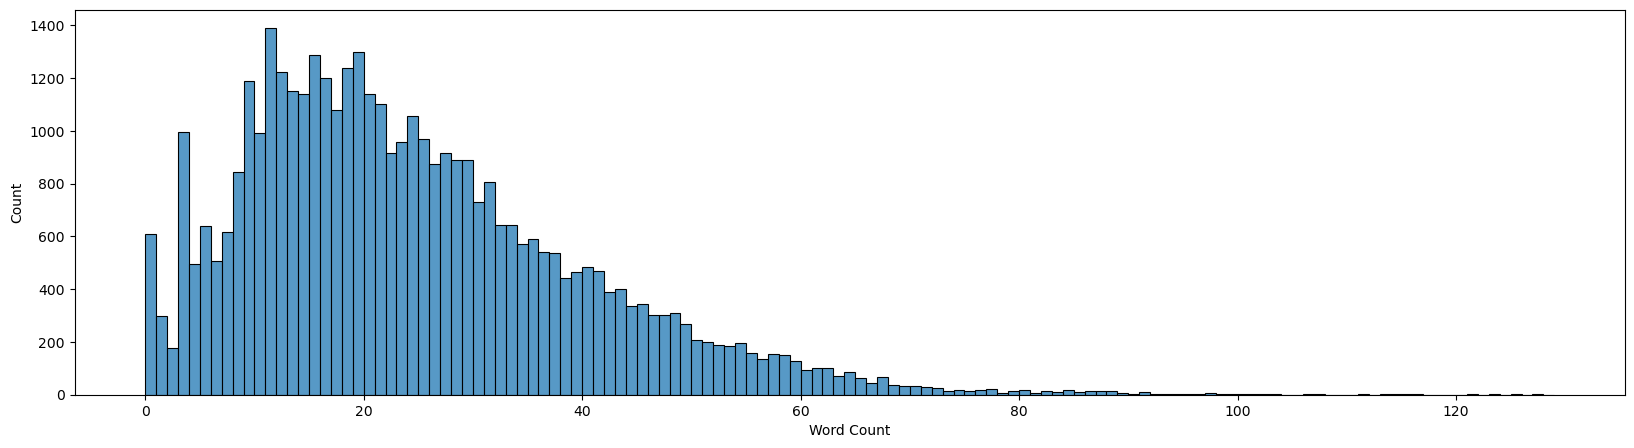

In [8]:
plt.figure(figsize=(20,5))
sns.histplot(cardsdf['Word Count'], bins=range(130))

## Step 4 - Plotting the Time Series and Final Analysis
Average Word Count by Set over time is plotted twice (below), using the Seaborn data visualization library and the standard Matplotlib library, respectively.

The increased density of observations in the last 5 years (the subject of a future analysis), makes visual analysis more difficult. Hence the second plot contains 4 subplots of each Set Type isolated from each other.

### All Sets Plotted Together
This plot of word counts over time shows an upward trend within the the last 5-10 years, with a more distinct signal in the last 3 years (2020-2023). 

<AxesSubplot:xlabel='Release Date', ylabel='Word Count'>

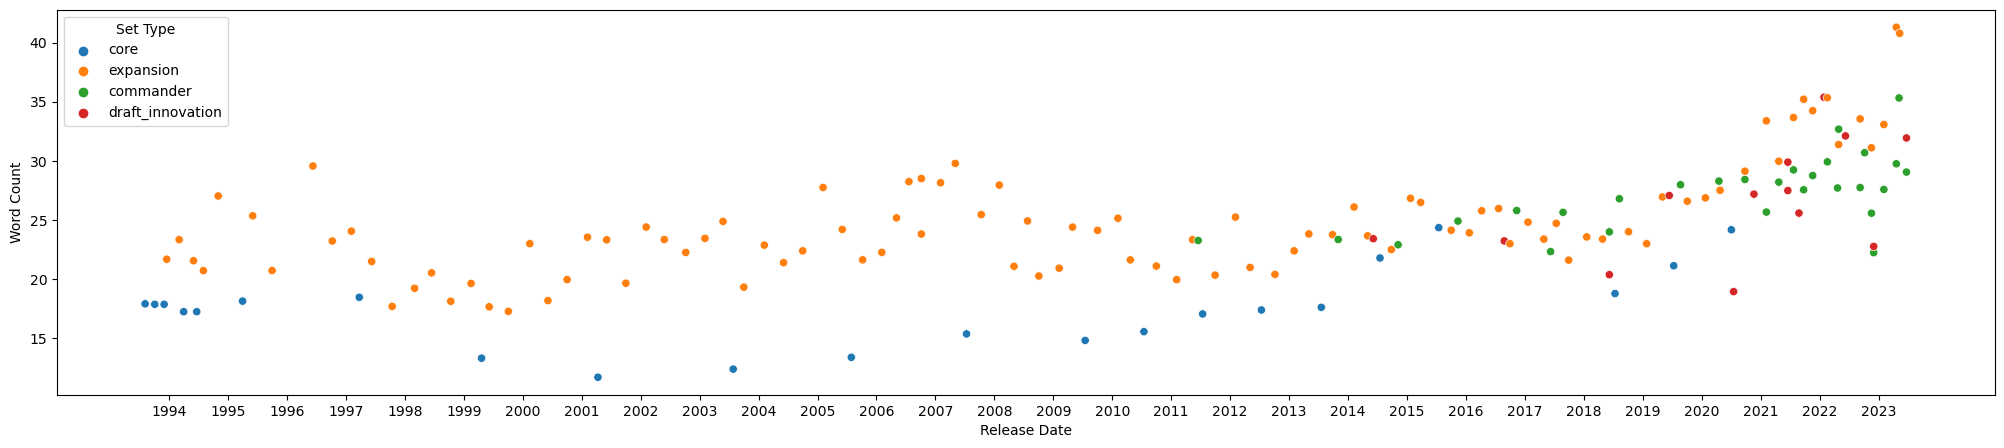

In [10]:
setmask = cardsdf.groupby('Set Name')

a=setmask['Word Count'].mean()
b=setmask['Release Date'].min()
c=setmask['Set Type'].last()
 
cdf = pd.merge(pd.merge(a,b, on='Set Name').sort_values(by = 'Release Date'),c, on ='Set Name').set_index('Release Date')

plt.figure(figsize=(25,5))
plt.xticks(pd.date_range(cdf.index.min(), cdf.index.max(), freq='YS'), labels = np.arange(1994, 2024, 1))
sns.scatterplot(x = cdf.index, y = cdf['Word Count'], hue = cdf['Set Type'])

### Isolated Plots by Set Type
The isolated plots - in particular the 'Expansion' Set type - show distinct upward trends in the most recent years. However, the last two plots also reveal a smaller number of observations from which to draw any conclusions.  

Text(0.5, 1.0, 'Average Word Count by Set in Magic: The Gathering 1993-2023')

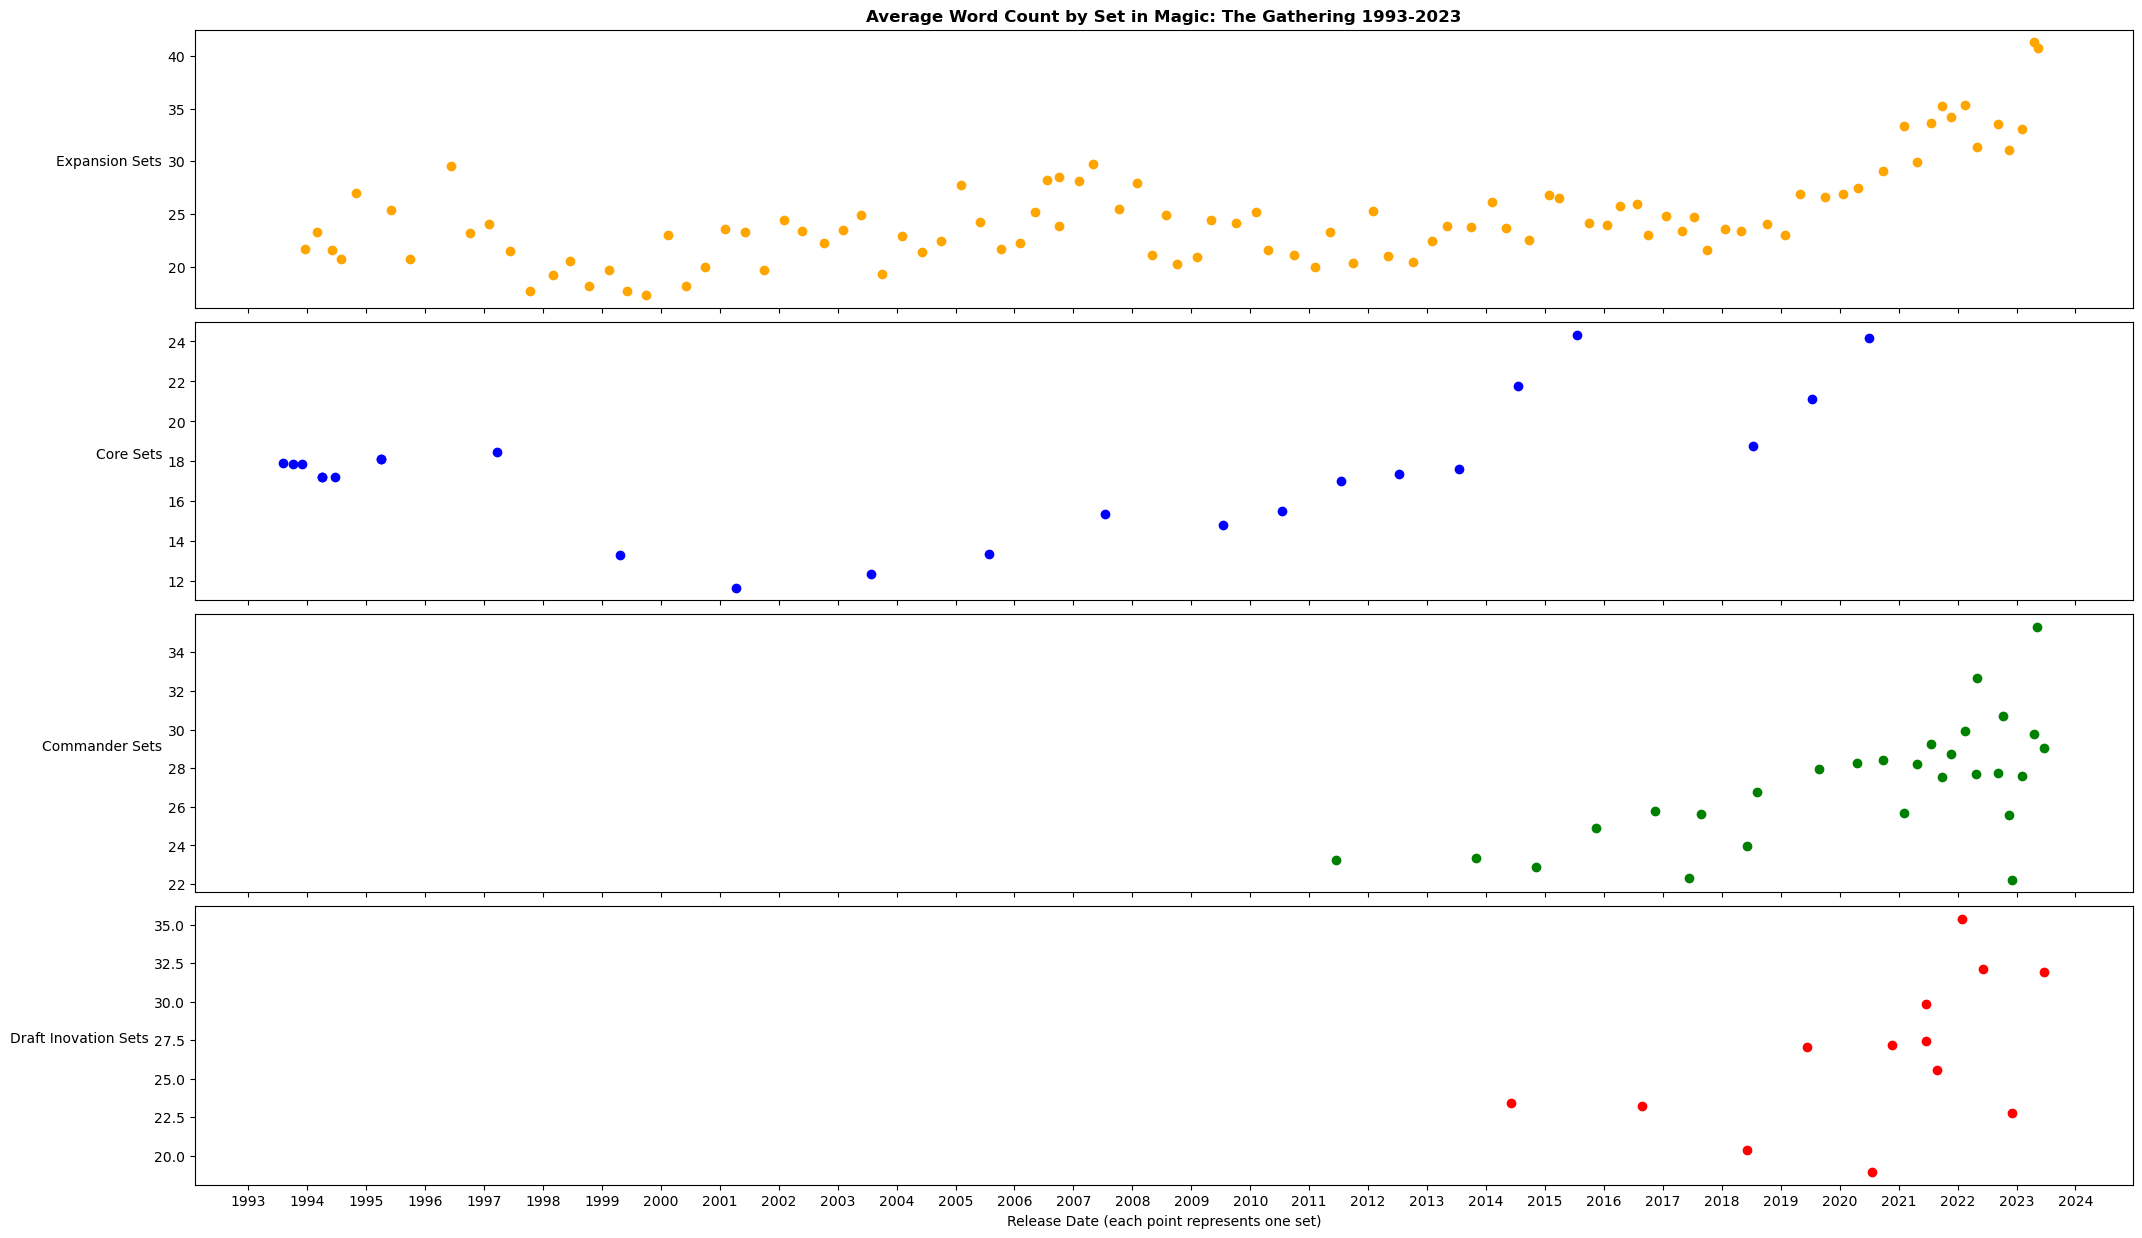

In [15]:
expansion = cdf[cdf['Set Type']=='expansion']
core = cdf[cdf['Set Type']=='core']
commander = cdf[cdf['Set Type']=='commander']
draftinnovation = cdf[cdf['Set Type']=='draft_innovation']

fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(25,15), sharex=True, gridspec_kw={'hspace':0.05})

ax1.scatter(x=expansion.index, y=expansion['Word Count'], label='Expansion', color='orange')
ax2.scatter(x=core.index, y=core['Word Count'], label='Core', color='blue')
ax3.scatter(x=commander.index, y=commander['Word Count'], label='Commander', color = 'green')
ax4.scatter(x=draftinnovation.index, y=draftinnovation['Word Count'], label='Draft Innovation', color = 'red')

ax1.xaxis.set_major_locator(mpl.dates.YearLocator())
ax1.set_ylabel('Expansion Sets', rotation = 'horizontal', ha='right')
ax2.set_ylabel('Core Sets', rotation = 'horizontal', ha='right')
ax3.set_ylabel('Commander Sets', rotation = 'horizontal', ha='right')
ax4.set_ylabel('Draft Inovation Sets', rotation = 'horizontal', ha='right')

ax4.set_xlabel('Release Date (each point represents one set)')
ax1.set_title('Average Word Count by Set in Magic: The Gathering 1993-2023', fontsize='large', fontweight='bold')
#ax.legend(title='Set Type')


### Further Analysis

From 1993 - 2020, the maximum average word count for any set was 29 words per card. <br> From 2021 - 2023, the *minimum* average word count for any set was 29 words per card.  

In [21]:
expansion[expansion.index > pd.to_datetime('1/1/2021')].min()

Word Count    29.957143
Set Type      expansion
dtype: object

In [23]:
expansion[expansion.index < pd.to_datetime('1/1/2021')].max()

Word Count    29.772222
Set Type      expansion
dtype: object